# Surrogate analysis for the daily mean LST at all points

## Setting up

### Import packages here

In [1]:
import pickle
from xarray import open_dataset
from numpy import (sqrt, append, isnan, datetime64, arange, linspace, zeros, sum, array, dot, stack
    ,maximum, minimum, fmax, fmin, ceil, sign)
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
#from numpoly import ndpoly

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import colorbar, colors
#from matplotlib.tri import Triangulation
#from cartopy.crs import PlateCarree
#from cartopy.feature import NaturalEarthFeature
#from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# some parameters
plt.rcParams.update({'font.size': 14})
#dpi = 200

In [2]:
from wrf_fvcom.variables import (
    WRF_PBL_SFCLAY, WRF_WaterZ0, WRF_MP, WRF_RA, WRF_LM,
    FVCOM_Prandtl, FVCOM_SWRadiationAbsorption,
    FVCOM_VerticalMixing, FVCOM_WindStress,
)
from wrf_fvcom.perturb import (
    transform_perturbation_matrix,
)
from surrogate.nn_regression import make_nn_surrogate_model
from surrogate.pc_regression import make_pc_surrogate_model
from surrogate.utils import surrogate_model_predict
from surrogate.gsa import compute_sensitivities, plot_sens

### Set the variables to analyze and get list of filenames

In [3]:
# time start and end 
ts = datetime64('2018-06-01')
te = datetime64('2018-09-01')

# choose variables want to analyze..
variables = [WRF_PBL_SFCLAY,
             WRF_MP, 
             WRF_RA,
             WRF_WaterZ0,
             WRF_LM,
             FVCOM_VerticalMixing,
             FVCOM_WindStress,
             FVCOM_Prandtl,
             FVCOM_SWRadiationAbsorption,
            ]

# get the variable names as a list
variable_names = [variable.name for variable in variables]

# test set does not have WRF_LM inside
variable_names_test = [variable.name for variable in variables if variable is not WRF_LM]
no_name_I = [4]
test_run_I = [0,2,4,5,8]

In [4]:
#filenames
train_parameters_file = '../output/perturbation_matrix_9variables_korobov18.nc'
test_parameters_file = '../output/perturbation_matrix_8variables_korobov19.nc'
train_output_filename = '../output/wfv_global_daily_temperature_training_set.pkl'
test_output_filename = '../output/wfv_global_daily_temperature_test_set.pkl'

#surrogate output filename
surrogate_output_filename = '../output/LST_klsurrogate_models.pkl'

# fvcom grid
# directories
proj_dir = '/lus/grand/projects/COMPASS-GLM/WRF+FVCOM_Sensitivity/'
fvcom_grid_file = proj_dir + 'fvcom_grid.nc' 

## Load inputs 

In [5]:
# fvcom grid
fvcom = open_dataset(fvcom_grid_file,decode_times=False, drop_variables=['siglay', 'siglev'])

In [6]:
## parameter info

# Get parameter training range and ensemble
params = open_dataset(train_parameters_file)
pnames = params.sel(variable=variable_names).variable.values
ptrain = params.sel(variable=variable_names).perturbation_matrix

# transform the input matrix
variable_matrix_train = transform_perturbation_matrix(ptrain)

In [7]:
# Get parameter test range and ensemble
params_t = open_dataset(test_parameters_file)
pnames_t = params_t.sel(variable=variable_names_test).isel(run=test_run_I).variable.values

# combining both sets of runs
ptest_t = params_t.sel(variable=variable_names_test).isel(run=test_run_I).perturbation_matrix
#
# transform into same variable number as train set and put value of 1 for Land Model
ptest = ptrain.isel(run=test_run_I)
ptest[:,[idx for idx, var_name in enumerate(variable_names) if idx not in no_name_I]] = ptest_t.values
ptest[:,no_name_I] = 1

# transform the input matrix
variable_matrix_test_t = transform_perturbation_matrix(ptest)
# transform into same scheme number as train set and put value of 0 where doesn't exist
variable_matrix_test = variable_matrix_train.isel(run=test_run_I)
scheme_names = variable_matrix_test['scheme'].values
no_scheme_I = [idx for idx, scheme_name in enumerate(scheme_names)
               if scheme_name not in variable_matrix_test_t['scheme'].values]
variable_matrix_test[:,[idx for idx, scheme_name in enumerate(scheme_names) if idx not in no_scheme_I]] = \
    variable_matrix_test_t.values
variable_matrix_test[:,no_scheme_I] = 0

In [8]:
## data info

#load the training data
with open(train_output_filename, 'rb') as fp:
    train_dict = pickle.load(fp)
    print('Done loading training data from binary file')
    
with open(test_output_filename, 'rb') as fp:
    test_dict = pickle.load(fp)
    print('Done loading test data from binary file')

Done loading training data from binary file
Done loading test data from binary file


In [9]:
# Get and check train sizes
nens = len(train_dict['runs'])
ntime = train_dict['LST'][0][0].shape[0]
ntime_, ngrid = train_dict['LST'][0][1].shape
nens_ = len(train_dict['LST'])
nens__, ndim = variable_matrix_train.shape

# sanity check
assert(ntime==ntime_)
assert(nens==nens_)
assert(nens==nens__)

# Print useful info
print('Training set info:')
print(f'Ensembles size : {nens}')
print(f'Parameter dim : {ndim}')
print(f'Timeseries size : {ntime}')
print(f'Spatial size: {ngrid}')

nens_train = nens

Training set info:
Ensembles size : 18
Parameter dim : 20
Timeseries size : 112
Spatial size: 35749


In [10]:
# Get and check train sizes
nens = len(test_dict['runs'])
ntime = test_dict['LST'][0][0].shape[0]
ntime_, ngrid = test_dict['LST'][0][1].shape
nens_ = len(test_dict['LST'])
nens__, ndim = variable_matrix_test.shape

# sanity check
assert(ntime==ntime_)
assert(nens==nens_)
assert(nens==nens__)

# Print useful info
print('Test set info:')
print(f'Ensembles size : {nens}')
print(f'Parameter dim : {ndim}')
print(f'Timeseries size : {ntime}')
print(f'Spatial size: {ngrid}')

nens_test = nens

Test set info:
Ensembles size : 5
Parameter dim : 20
Timeseries size : 112
Spatial size: 35749


In [11]:
# construct the training data into right dimensions
for rdx, run in enumerate(train_dict['LST']):
    tdx = (run[0] >= ts) & (run[0] < te)
    ntime2 = tdx.sum()
    value_temp = run[1].isel(time=tdx).values.reshape(1,-1)
    if rdx == 0:
        trainY = value_temp
    else:
        trainY = append(trainY,value_temp,axis=0)
display(trainY.shape)
        
# construct the training data into right dimensions
for rdx, run in enumerate(test_dict['LST']):
    tdx = (run[0] >= ts) & (run[0] < te)
    ntime2_ = tdx.sum()
    value_temp = run[1].isel(time=tdx).values.reshape(1,-1)
    if rdx == 0:
        testY = value_temp
    else:
        testY = append(testY,value_temp,axis=0)
        
display(testY.shape)

(18, 3288908)

(5, 3288908)

##  Construct surrogate models

In [22]:
# some variables for surrogate
var_explained = len(variables) #for PCA

# using hot_enconding or not
hot_encode = True
# setup training and test inputs based on onehotencoding or not
if hot_encode:
    train_x = variable_matrix_train
    test_x = variable_matrix_test
else:
    train_x = ptrain
    test_x = ptest

# PC surrogate model parameters
polynomial_order = 2
regression_type = 'ElasticNet'

# NN surrogate model parameters
batch_size = nens_train // 3 #5 K-Fold
hidden_layers = 10
learn_rate = 0.001
nepochs=5000

# randomization
random_seeds = range(111,999+111,222)
#seed = 666 # val_loss = 0.71 , BO gives ??
#seed = 111 # val_loss = 0.67,  BO gives BO1 parameters
#seed = 99 # val_loss = 0.73 , BO gives BO1 except COARE, GOTM k-eps
#seed = 222 # val_loss = 0.66, BO gives BO1 except COARE, GOTM k-eps
#seed = None

# initialize the surrogate dictionary
kl_surrogate = dict()

n_folds = 5 #number k folds

### Decompose the time series

In [13]:
# Decompose the spatiotemporal series using PCA/KL
pca_obj = PCA(n_components=var_explained, 
              random_state=random_seeds[0], 
              whiten=True)
pca_obj.fit(trainY)

PCA(n_components=9, random_state=111, whiten=True)

In [14]:
# get the outputs from the PCA
klxi_train = pca_obj.transform(trainY)
klxi_test  = pca_obj.transform(testY)
eigenratio = pca_obj.explained_variance_ratio_
print(eigenratio)
print(eigenratio.sum())
neig = pca_obj.n_components_
eigenvalues = pca_obj.explained_variance_
eigenmodes = pca_obj.components_
mean_vector = pca_obj.mean_
print(f'number of eigenmodes is {neig}')

[0.59524146 0.10616204 0.04990378 0.04276877 0.03184092 0.0306296
 0.02111236 0.0180193  0.01771278]
0.9133910082750212
number of eigenmodes is 9


In [15]:
# Check the error of PCA for test is similar to train
print(f'PCA train mean abs error: {(abs(pca_obj.inverse_transform(klxi_train) - trainY)).mean()}')
print(f'PCA test mean abs error: {(abs(pca_obj.inverse_transform(klxi_test) - testY)).mean()}')

PCA train mean abs error: 0.19694867240824765
PCA test mean abs error: 0.37530686991760287


In [16]:
print(f'PCA train std error: {(pca_obj.inverse_transform(klxi_train) - trainY).std()}')
print(f'PCA test std error: {(pca_obj.inverse_transform(klxi_test) - testY).std()}')

PCA train std error: 0.2705900326792565
PCA test std error: 0.5217007675333669


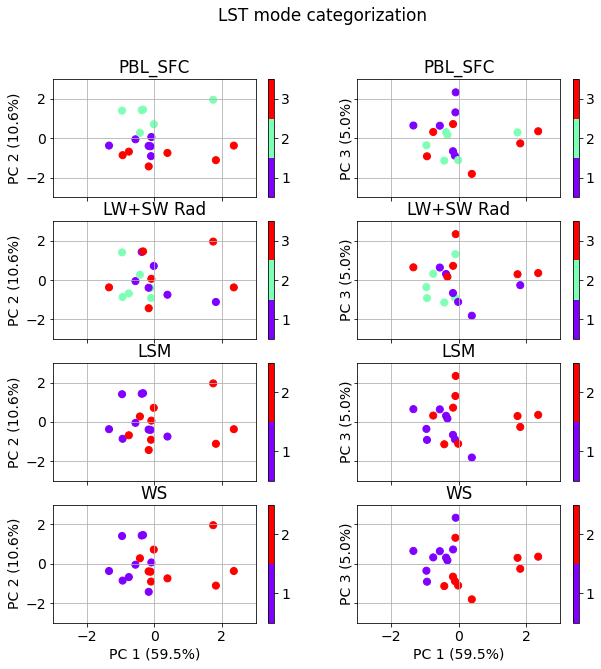

In [17]:
labels = [
    f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(eigenratio * 100)
]
important_variables = [WRF_PBL_SFCLAY, WRF_RA, WRF_LM, FVCOM_WindStress]
pname_paper = ['PBL_SFC', 'LW+SW Rad', 'LSM', 'WS']
bnds = 3

fig, axs = plt.subplots(len(important_variables), 2,sharey=True,sharex=True,figsize=(10,10))
for vv,var in enumerate(important_variables):
    cat = ptrain.sel(variable=var.name).values
    cmap = plt.cm.rainbow
    catrange = arange(cat.min()-0.5, cat.max()+1.5, 1)
    norm = colors.BoundaryNorm(catrange, cmap.N)
    for ii in [0,1]:
        py = axs[vv,ii].scatter(klxi_train[:,0],klxi_train[:,ii+1],s=50,c=cat, cmap=cmap, norm=norm)
        if vv == len(important_variables)-1:
            axs[vv,ii].set_xlabel(labels[0])
        axs[vv,ii].set_ylabel(labels[ii+1])
        axs[vv,ii].grid()
        axs[vv,ii].set_xlim([-bnds,bnds])
        axs[vv,ii].set_ylim([-bnds,bnds])
        plt.colorbar(py,ax=axs[vv,ii],ticks=catrange+0.5)
        axs[vv,ii].set_title(pname_paper[vv])
plt.suptitle('LST mode categorization')
plt.show()

### Train and check the PC model

In [25]:
# Polynomial Chaos
kl_surrogate['PC'] = list()
for random_seed in random_seeds:
    print(random_seed)
    kl_surrogate['PC'].append(
        make_pc_surrogate_model(
        train_x, klxi_train, polynomial_order=polynomial_order, regressor=regression_type,
        cv=KFold(n_splits=n_folds, shuffle=True, random_state=random_seed),
        )
    )

111


/home/wpringle/.conda/envs/wrf-env/lib/python3.8/site-packages/chaospy/recurrence/stieltjes.py:152: RuntimeWarning: invalid value encountered in double_scalars
  coeffs[:, order] = (inner / norms[-1], norms[-1] / norms[-2])
/home/wpringle/.conda/envs/wrf-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.577e-03, tolerance: 1.700e-03
  model = cd_fast.enet_coordinate_descent(


333


/home/wpringle/.conda/envs/wrf-env/lib/python3.8/site-packages/chaospy/recurrence/stieltjes.py:152: RuntimeWarning: invalid value encountered in double_scalars
  coeffs[:, order] = (inner / norms[-1], norms[-1] / norms[-2])


555


/home/wpringle/.conda/envs/wrf-env/lib/python3.8/site-packages/chaospy/recurrence/stieltjes.py:152: RuntimeWarning: invalid value encountered in double_scalars
  coeffs[:, order] = (inner / norms[-1], norms[-1] / norms[-2])


777


/home/wpringle/.conda/envs/wrf-env/lib/python3.8/site-packages/chaospy/recurrence/stieltjes.py:152: RuntimeWarning: invalid value encountered in double_scalars
  coeffs[:, order] = (inner / norms[-1], norms[-1] / norms[-2])


999


/home/wpringle/.conda/envs/wrf-env/lib/python3.8/site-packages/chaospy/recurrence/stieltjes.py:152: RuntimeWarning: invalid value encountered in double_scalars
  coeffs[:, order] = (inner / norms[-1], norms[-1] / norms[-2])
/home/wpringle/.conda/envs/wrf-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.577e-03, tolerance: 1.700e-03
  model = cd_fast.enet_coordinate_descent(
/home/wpringle/.conda/envs/wrf-env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.970e-03, tolerance: 1.700e-03
  model = cd_fast.enet_coordinate_descent(


### Train and check the NN model

111
   NEpochs   NUpdates  BatchLoss    TrnLoss    ValLoss BestLoss(Epoch)    LrnRate
         1          3   0.993307   0.857395   0.853763     0.853763(0)   0.001000
       100        300   0.506318   0.447525   0.444130     0.444130(99)   0.001000
       200        600   0.201984   0.207648   0.207042     0.207042(199)   0.001000
       300        900   0.133782   0.146380   0.146082     0.146082(299)   0.001000
       400       1200   0.116884   0.119092   0.118982     0.118982(399)   0.001000
       500       1500   0.114128   0.106359   0.106288     0.106288(499)   0.001000
       600       1800   0.079047   0.097132   0.097064     0.097064(599)   0.001000
       700       2100   0.078473   0.087633   0.087570     0.087570(699)   0.001000
       800       2400   0.058932   0.078770   0.078712     0.078712(799)   0.001000
       900       2700   0.083381   0.071235   0.071188     0.071188(899)   0.001000
      1000       3000   0.052062   0.064077   0.064041     0.064041(999)   0.

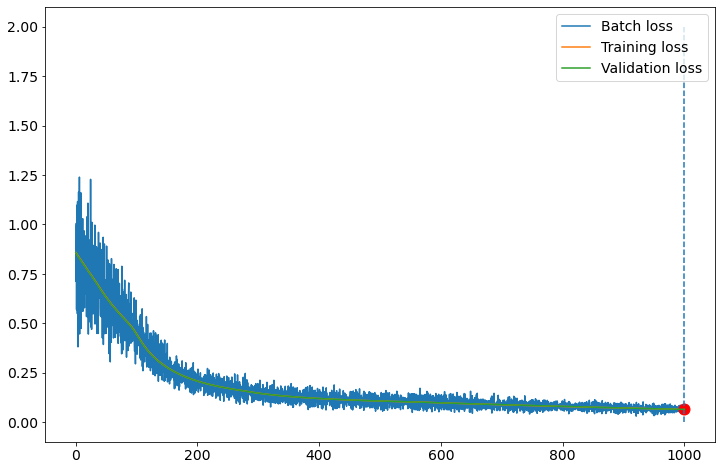

      1100       3300   0.082717   0.059545   0.059521     0.059521(1099)   0.001000
      1200       3600   0.073290   0.056426   0.056407     0.056407(1199)   0.001000
      1300       3900   0.048333   0.054137   0.054126     0.054126(1299)   0.001000
      1400       4200   0.065020   0.052352   0.052344     0.052344(1399)   0.001000
      1500       4500   0.033001   0.050910   0.050898     0.050898(1499)   0.001000
      1600       4800   0.052465   0.049512   0.049504     0.049504(1599)   0.001000
      1700       5100   0.051684   0.048302   0.048298     0.048298(1699)   0.001000
      1800       5400   0.052410   0.047441   0.047436     0.047436(1799)   0.001000
      1900       5700   0.051590   0.046761   0.046758     0.046758(1899)   0.001000
      2000       6000   0.033660   0.046209   0.046201     0.046201(1999)   0.001000


<Figure size 432x288 with 0 Axes>

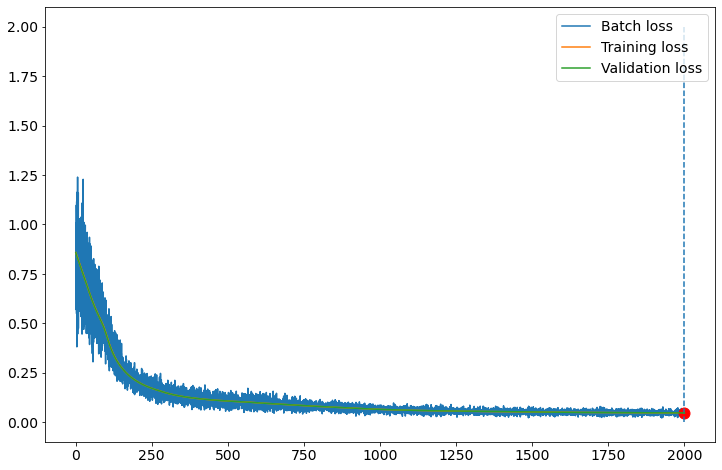

      2100       6300   0.037706   0.045754   0.045745     0.045745(2099)   0.001000
      2200       6600   0.028162   0.045362   0.045367     0.045362(2199)   0.001000
      2300       6900   0.040709   0.045049   0.045048     0.045048(2299)   0.001000
      2400       7200   0.035138   0.044778   0.044792     0.044778(2399)   0.001000
      2500       7500   0.053387   0.044553   0.044551     0.044551(2499)   0.001000
      2600       7800   0.038295   0.044351   0.044349     0.044349(2599)   0.001000
      2700       8100   0.045684   0.044178   0.044175     0.044175(2699)   0.001000
      2800       8400   0.038610   0.044022   0.044023     0.044021(2799)   0.001000
      2900       8700   0.037369   0.043883   0.043891     0.043883(2899)   0.001000
      3000       9000   0.036906   0.043765   0.043763     0.043757(2997)   0.001000


<Figure size 432x288 with 0 Axes>

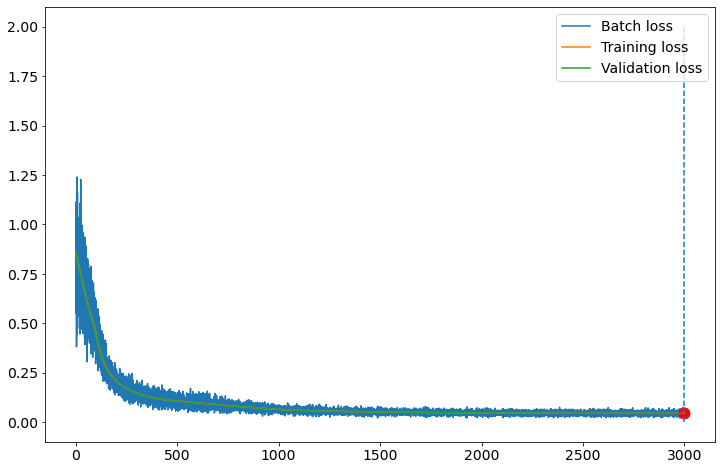

      3100       9300   0.043934   0.043644   0.043649     0.043644(3099)   0.001000
      3200       9600   0.042332   0.043537   0.043538     0.043537(3199)   0.001000
      3300       9900   0.046252   0.043439   0.043440     0.043439(3298)   0.001000
      3400      10200   0.029696   0.043206   0.043208     0.043206(3399)   0.001000
      3500      10500   0.051913   0.043090   0.043092     0.043089(3498)   0.001000
      3600      10800   0.042663   0.042991   0.042992     0.042986(3598)   0.001000
      3700      11100   0.049863   0.042912   0.042898     0.042895(3697)   0.001000
      3800      11400   0.038544   0.042808   0.042803     0.042803(3799)   0.001000
      3900      11700   0.039029   0.042715   0.042720     0.042715(3899)   0.001000
      4000      12000   0.039082   0.042630   0.042627     0.042627(3999)   0.001000


<Figure size 432x288 with 0 Axes>

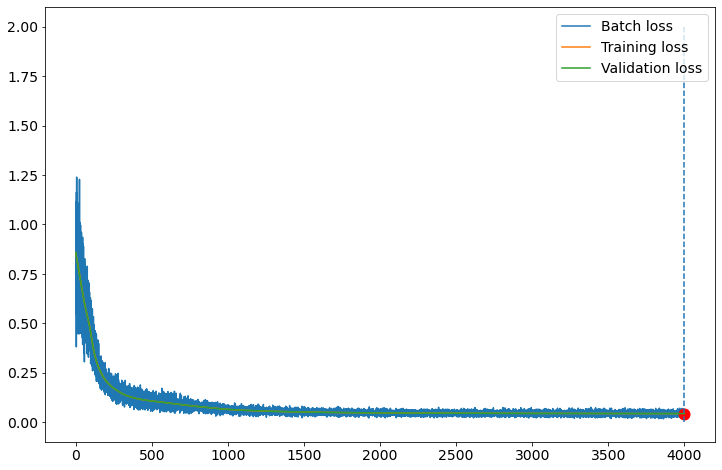

      4100      12300   0.043284   0.042548   0.042548     0.042548(4098)   0.001000
      4200      12600   0.042792   0.042467   0.042477     0.042467(4199)   0.001000
      4300      12900   0.031483   0.042392   0.042396     0.042390(4298)   0.001000
      4400      13200   0.025800   0.042318   0.042313     0.042311(4396)   0.001000
      4500      13500   0.031783   0.042233   0.042233     0.042233(4499)   0.001000
      4600      13800   0.048424   0.042157   0.042162     0.042157(4599)   0.001000
      4700      14100   0.045560   0.042090   0.042083     0.042081(4698)   0.001000
      4800      14400   0.039548   0.042009   0.042007     0.042005(4797)   0.001000
      4900      14700   0.053035   0.041947   0.041941     0.041935(4896)   0.001000
      5000      15000   0.024382   0.041864   0.041860     0.041858(4996)   0.001000


<Figure size 432x288 with 0 Axes>

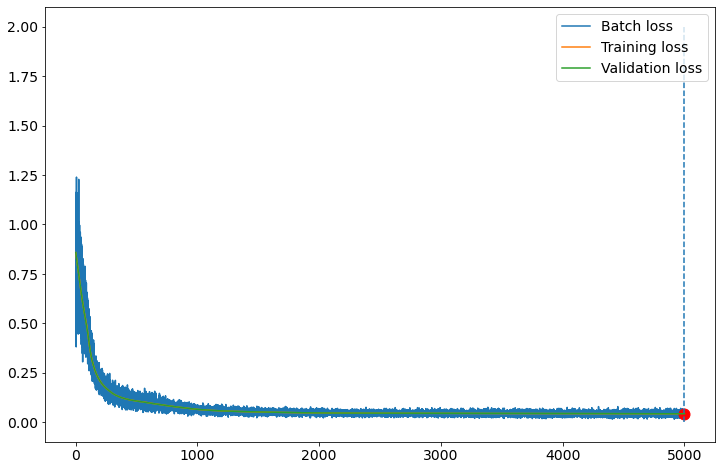

333
   NEpochs   NUpdates  BatchLoss    TrnLoss    ValLoss BestLoss(Epoch)    LrnRate
         1          3   1.084992   0.906301   0.901979     0.901979(0)   0.001000
       100        300   0.282493   0.311884   0.310416     0.310416(99)   0.001000
       200        600   0.173292   0.180623   0.180120     0.180120(199)   0.001000
       300        900   0.099274   0.128732   0.128464     0.128464(299)   0.001000
       400       1200   0.085978   0.096157   0.095957     0.095957(399)   0.001000
       500       1500   0.076714   0.073106   0.072980     0.072980(499)   0.001000
       600       1800   0.058624   0.057696   0.057613     0.057613(599)   0.001000
       700       2100   0.050385   0.047577   0.047526     0.047526(699)   0.001000
       800       2400   0.030786   0.040225   0.040178     0.040178(799)   0.001000
       900       2700   0.038541   0.034121   0.034089     0.034089(899)   0.001000
      1000       3000   0.018731   0.028925   0.028893     0.028893(999)   0.

<Figure size 432x288 with 0 Axes>

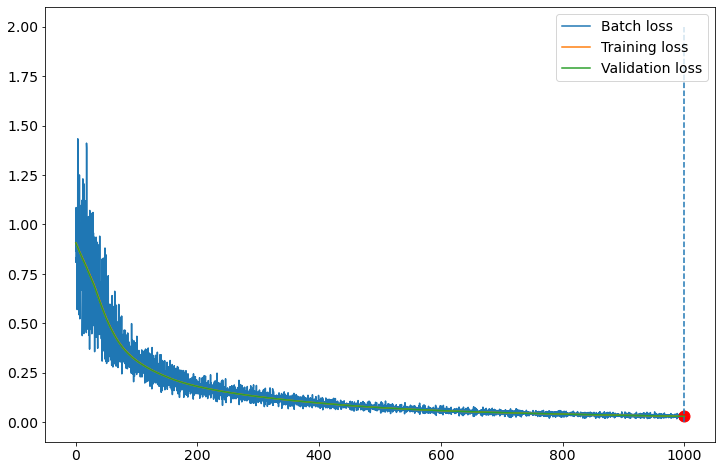

      1100       3300   0.026374   0.024165   0.024136     0.024136(1099)   0.001000
      1200       3600   0.020017   0.020042   0.020014     0.020014(1199)   0.001000
      1300       3900   0.012239   0.016376   0.016349     0.016349(1299)   0.001000
      1400       4200   0.015276   0.013245   0.013228     0.013228(1399)   0.001000
      1500       4500   0.013222   0.010671   0.010656     0.010656(1499)   0.001000
      1600       4800   0.006652   0.008588   0.008576     0.008576(1599)   0.001000
      1700       5100   0.007539   0.006941   0.006934     0.006934(1699)   0.001000
      1800       5400   0.003570   0.005649   0.005642     0.005642(1799)   0.001000
      1900       5700   0.004108   0.004658   0.004652     0.004652(1899)   0.001000
      2000       6000   0.003041   0.003882   0.003879     0.003879(1999)   0.001000


<Figure size 432x288 with 0 Axes>

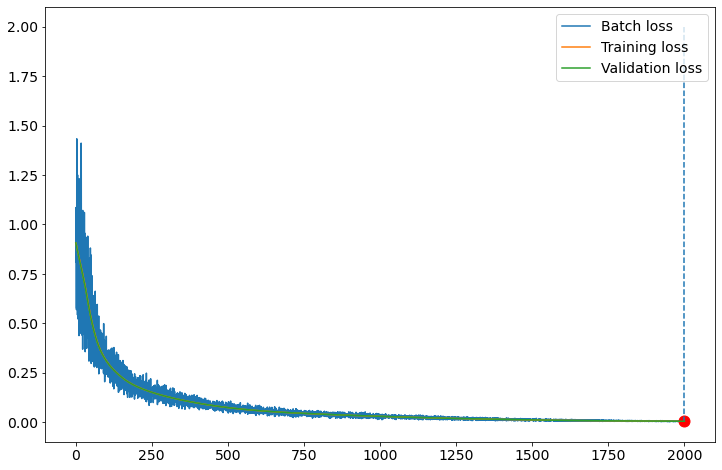

      2100       6300   0.003486   0.003280   0.003278     0.003277(2099)   0.001000
      2200       6600   0.001707   0.002813   0.002807     0.002807(2199)   0.001000
      2300       6900   0.001643   0.002432   0.002432     0.002432(2299)   0.001000
      2400       7200   0.001527   0.002126   0.002122     0.002122(2399)   0.001000
      2500       7500   0.002265   0.001873   0.001871     0.001871(2499)   0.001000
      2600       7800   0.002446   0.001670   0.001666     0.001666(2599)   0.001000
      2700       8100   0.001452   0.001496   0.001494     0.001494(2699)   0.001000
      2800       8400   0.001699   0.001353   0.001355     0.001352(2798)   0.001000
      2900       8700   0.000702   0.001232   0.001236     0.001230(2896)   0.001000
      3000       9000   0.001569   0.001116   0.001130     0.001104(2996)   0.001000


<Figure size 432x288 with 0 Axes>

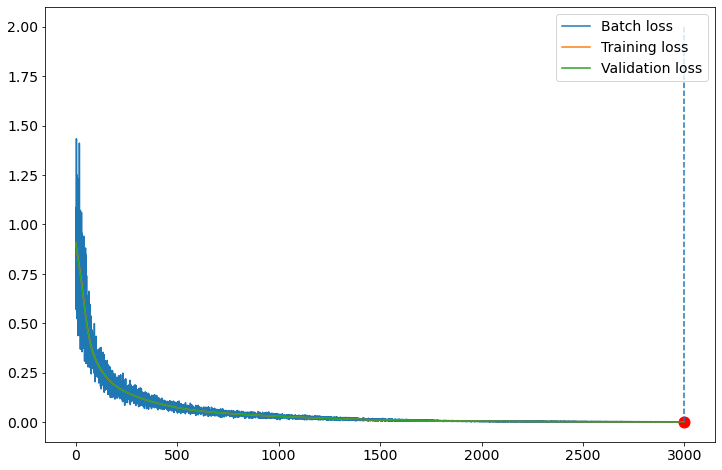

      3100       9300   0.001493   0.000995   0.000994     0.000994(3099)   0.001000
      3200       9600   0.000675   0.000911   0.000909     0.000909(3199)   0.001000
      3300       9900   0.000658   0.000839   0.000836     0.000836(3299)   0.001000
      3400      10200   0.000499   0.000771   0.000770     0.000770(3399)   0.001000
      3500      10500   0.001028   0.000736   0.000786     0.000727(3493)   0.001000
      3600      10800   0.000609   0.000669   0.000669     0.000669(3599)   0.001000
      3700      11100   0.000552   0.000629   0.000630     0.000627(3698)   0.001000
      3800      11400   0.000727   0.000589   0.000589     0.000589(3799)   0.001000
      3900      11700   0.000676   0.000555   0.000556     0.000555(3899)   0.001000
      4000      12000   0.000790   0.000524   0.000523     0.000523(3999)   0.001000


<Figure size 432x288 with 0 Axes>

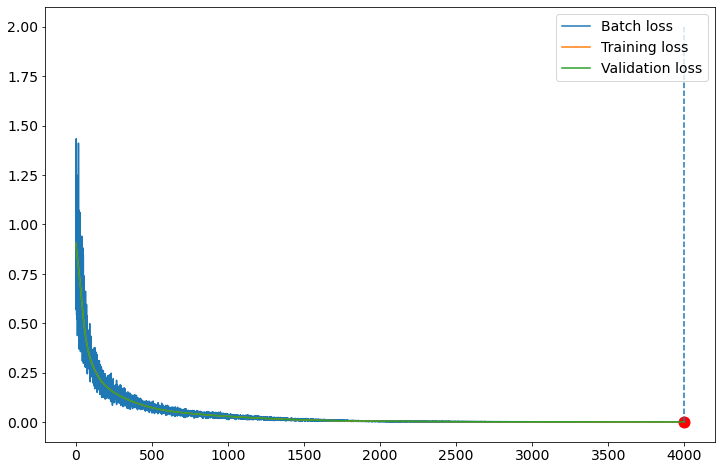

      4100      12300   0.000554   0.000497   0.000496     0.000496(4099)   0.001000
      4200      12600   0.000461   0.000472   0.000472     0.000471(4197)   0.001000
      4300      12900   0.000926   0.000560   0.000877     0.000457(4261)   0.001000
      4400      13200   0.000348   0.000432   0.000430     0.000430(4399)   0.001000
      4500      13500   0.000327   0.000415   0.000429     0.000414(4492)   0.001000
      4600      13800   0.000402   0.000408   0.000417     0.000397(4588)   0.001000
      4700      14100   0.000491   0.000377   0.000377     0.000376(4698)   0.001000
      4800      14400   0.000608   0.000376   0.000466     0.000363(4779)   0.001000
      4900      14700   0.000237   0.000347   0.000351     0.000347(4899)   0.001000
      5000      15000   0.000341   0.000335   0.000340     0.000333(4997)   0.001000


<Figure size 432x288 with 0 Axes>

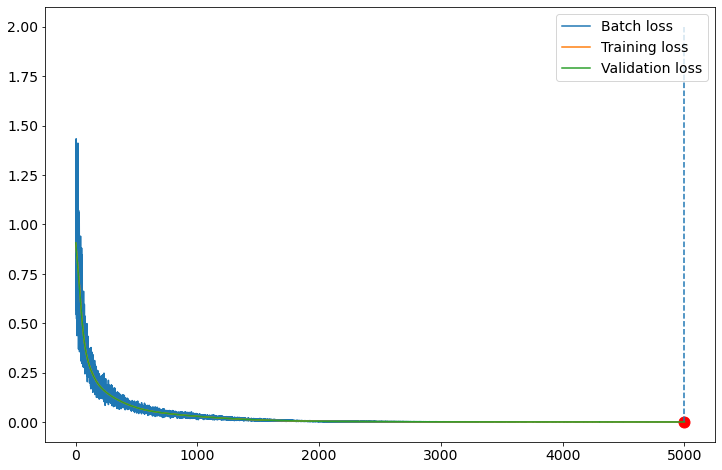

555
   NEpochs   NUpdates  BatchLoss    TrnLoss    ValLoss BestLoss(Epoch)    LrnRate
         1          3   0.937813   0.909432   0.902347     0.902347(0)   0.001000
       100        300   0.475291   0.302209   0.300081     0.300081(99)   0.001000
       200        600   0.105282   0.122793   0.122294     0.122294(199)   0.001000
       300        900   0.107060   0.078873   0.078695     0.078695(299)   0.001000
       400       1200   0.079870   0.056918   0.056793     0.056793(399)   0.001000
       500       1500   0.031288   0.042214   0.042131     0.042131(499)   0.001000
       600       1800   0.043088   0.030694   0.030643     0.030643(599)   0.001000
       700       2100   0.023399   0.022804   0.022754     0.022754(699)   0.001000
       800       2400   0.019572   0.016722   0.016687     0.016687(799)   0.001000
       900       2700   0.011496   0.012558   0.012533     0.012533(899)   0.001000
      1000       3000   0.012038   0.009845   0.009833     0.009833(999)   0.

<Figure size 432x288 with 0 Axes>

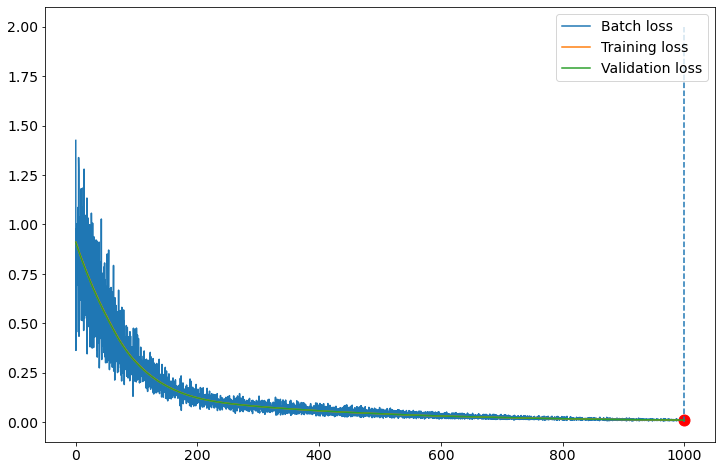

      1100       3300   0.008176   0.008059   0.008050     0.008050(1099)   0.001000
      1200       3600   0.006807   0.006809   0.006804     0.006804(1199)   0.001000
      1300       3900   0.005714   0.005832   0.005826     0.005826(1299)   0.001000
      1400       4200   0.004654   0.005095   0.005092     0.005092(1399)   0.001000
      1500       4500   0.004729   0.004529   0.004525     0.004525(1499)   0.001000
      1600       4800   0.004226   0.004088   0.004086     0.004086(1599)   0.001000
      1700       5100   0.004141   0.003751   0.003753     0.003751(1699)   0.001000
      1800       5400   0.006845   0.003488   0.003487     0.003485(1799)   0.001000
      1900       5700   0.002934   0.002776   0.002773     0.002773(1899)   0.001000
      2000       6000   0.001831   0.002192   0.002190     0.002190(1999)   0.001000


<Figure size 432x288 with 0 Axes>

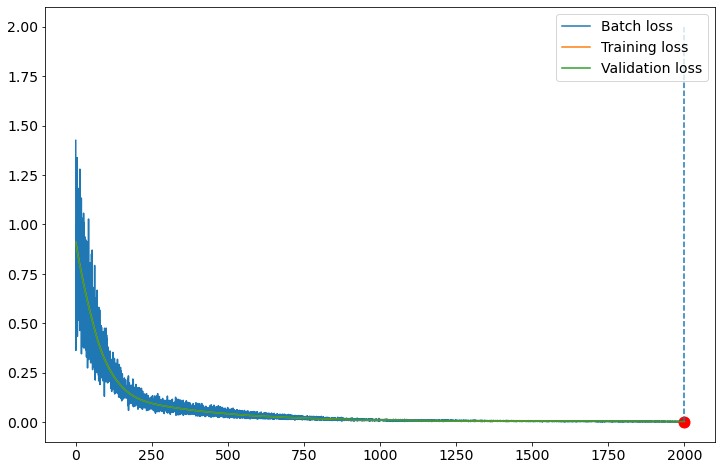

      2100       6300   0.001595   0.001766   0.001767     0.001766(2099)   0.001000
      2200       6600   0.001847   0.001448   0.001445     0.001445(2199)   0.001000
      2300       6900   0.000804   0.001201   0.001202     0.001196(2298)   0.001000
      2400       7200   0.001402   0.001103   0.001013     0.001000(2396)   0.001000
      2500       7500   0.000488   0.000828   0.000828     0.000828(2499)   0.001000
      2600       7800   0.000719   0.000702   0.000698     0.000698(2599)   0.001000
      2700       8100   0.000652   0.000595   0.000595     0.000595(2699)   0.001000
      2800       8400   0.000252   0.000512   0.000511     0.000511(2799)   0.001000
      2900       8700   0.000188   0.000444   0.000442     0.000442(2899)   0.001000
      3000       9000   0.000327   0.000412   0.000437     0.000391(2991)   0.001000


<Figure size 432x288 with 0 Axes>

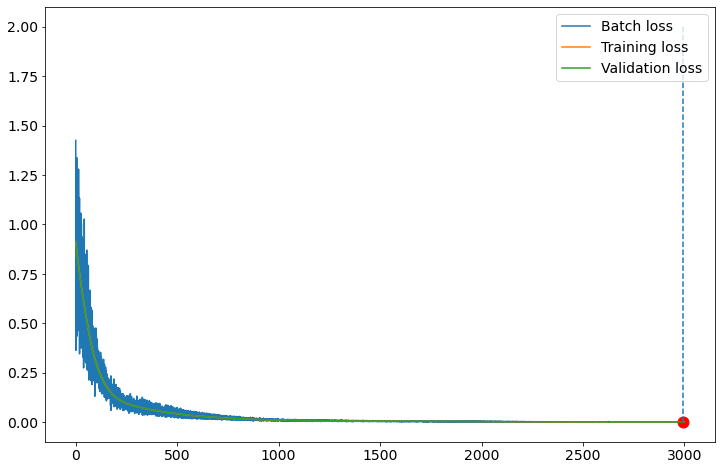

      3100       9300   0.000297   0.000343   0.000346     0.000343(3097)   0.001000
      3200       9600   0.000499   0.000428   0.000390     0.000310(3184)   0.001000
      3300       9900   0.000171   0.000279   0.000278     0.000274(3298)   0.001000
      3400      10200   0.000307   0.000249   0.000248     0.000248(3398)   0.001000
      3500      10500   0.000323   0.000229   0.000232     0.000229(3499)   0.001000
      3600      10800   0.000135   0.000213   0.000209     0.000206(3594)   0.001000
      3700      11100   0.000106   0.000301   0.000223     0.000192(3682)   0.001000
      3800      11400   0.000208   0.000176   0.000178     0.000176(3799)   0.001000
      3900      11700   0.000051   0.000166   0.000166     0.000166(3898)   0.001000
      4000      12000   0.000161   0.000167   0.000158     0.000156(3994)   0.001000


<Figure size 432x288 with 0 Axes>

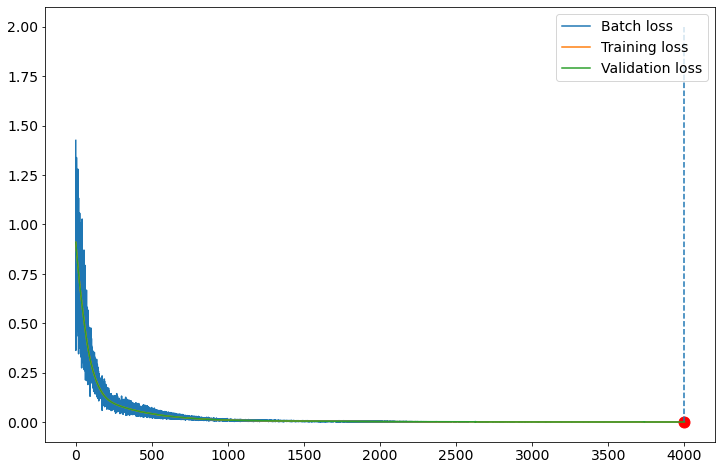

      4100      12300   0.000195   0.000175   0.000155     0.000151(4048)   0.001000
      4200      12600   0.000217   0.000139   0.000139     0.000138(4195)   0.001000
      4300      12900   0.000310   0.000154   0.000146     0.000137(4218)   0.001000
      4400      13200   0.000104   0.000124   0.000125     0.000123(4398)   0.001000
      4500      13500   0.000175   0.000144   0.000129     0.000118(4489)   0.001000
      4600      13800   0.000128   0.000191   0.000181     0.000113(4574)   0.001000
      4700      14100   0.000152   0.000106   0.000106     0.000105(4692)   0.001000
      4800      14400   0.000049   0.000100   0.000100     0.000100(4798)   0.001000
      4900      14700   0.000203   0.000099   0.000105     0.000096(4892)   0.001000
      5000      15000   0.000109   0.000096   0.000100     0.000095(4913)   0.001000


<Figure size 432x288 with 0 Axes>

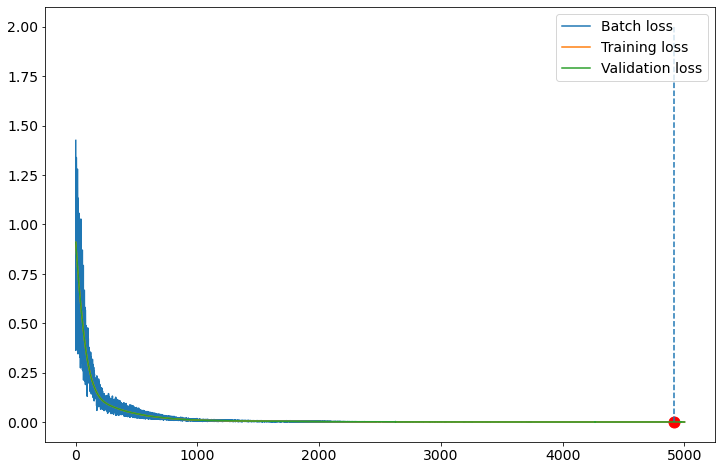

777
   NEpochs   NUpdates  BatchLoss    TrnLoss    ValLoss BestLoss(Epoch)    LrnRate
         1          3   0.453846   1.012937   1.002237     1.002237(0)   0.001000
       100        300   0.195542   0.316870   0.315277     0.315277(99)   0.001000
       200        600   0.114478   0.158976   0.158349     0.158349(199)   0.001000
       300        900   0.093861   0.095261   0.094999     0.094999(299)   0.001000
       400       1200   0.083571   0.067167   0.067036     0.067036(399)   0.001000
       500       1500   0.049064   0.051062   0.050970     0.050970(499)   0.001000
       600       1800   0.048956   0.038851   0.038783     0.038783(599)   0.001000
       700       2100   0.030281   0.028428   0.028366     0.028366(699)   0.001000
       800       2400   0.022480   0.020186   0.020137     0.020137(799)   0.001000
       900       2700   0.014836   0.014242   0.014210     0.014210(899)   0.001000
      1000       3000   0.012915   0.010241   0.010219     0.010219(999)   0.

<Figure size 432x288 with 0 Axes>

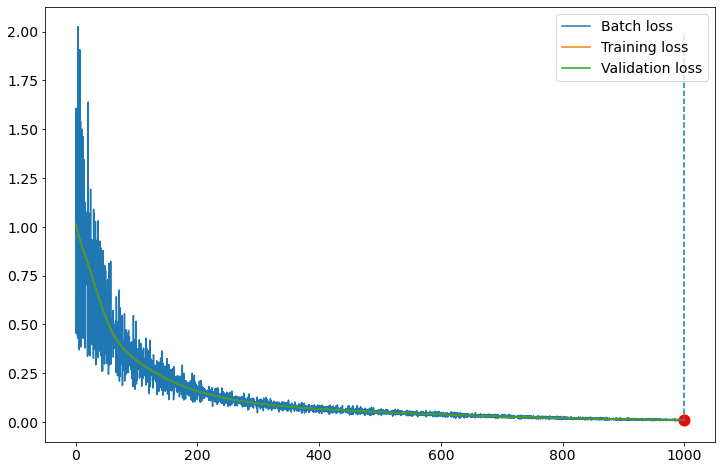

      1100       3300   0.008159   0.007345   0.007328     0.007328(1099)   0.001000
      1200       3600   0.004681   0.005267   0.005257     0.005257(1199)   0.001000
      1300       3900   0.005584   0.003885   0.003878     0.003878(1299)   0.001000
      1400       4200   0.003566   0.002947   0.002941     0.002941(1399)   0.001000
      1500       4500   0.002421   0.002304   0.002300     0.002300(1499)   0.001000
      1600       4800   0.002052   0.001855   0.001852     0.001852(1599)   0.001000
      1700       5100   0.001792   0.001524   0.001523     0.001523(1699)   0.001000
      1800       5400   0.001326   0.001256   0.001255     0.001255(1799)   0.001000
      1900       5700   0.000872   0.001033   0.001033     0.001033(1899)   0.001000
      2000       6000   0.000808   0.000845   0.000844     0.000844(1999)   0.001000


<Figure size 432x288 with 0 Axes>

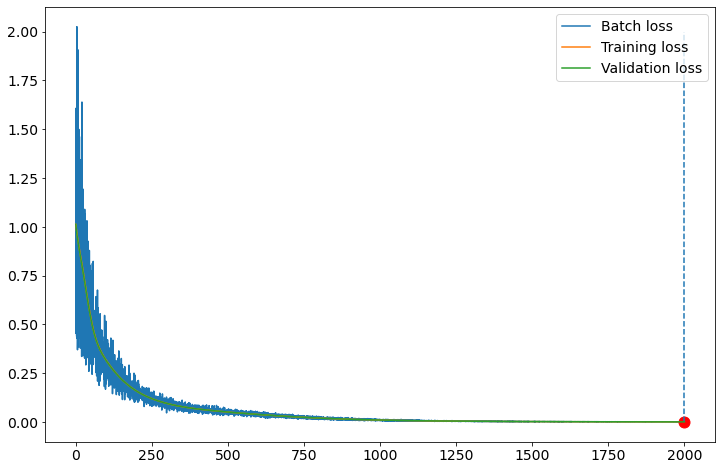

      2100       6300   0.001026   0.000686   0.000692     0.000686(2099)   0.001000
      2200       6600   0.000742   0.000554   0.000555     0.000553(2198)   0.001000
      2300       6900   0.000456   0.000452   0.000451     0.000443(2299)   0.001000
      2400       7200   0.000343   0.000350   0.000355     0.000350(2399)   0.001000
      2500       7500   0.000342   0.000282   0.000277     0.000277(2499)   0.001000
      2600       7800   0.000168   0.000216   0.000216     0.000216(2599)   0.001000
      2700       8100   0.000141   0.000184   0.000175     0.000172(2697)   0.001000
      2800       8400   0.000117   0.000137   0.000137     0.000136(2799)   0.001000
      2900       8700   0.000131   0.000125   0.000118     0.000115(2897)   0.001000
      3000       9000   0.000112   0.000091   0.000090     0.000090(2999)   0.001000


<Figure size 432x288 with 0 Axes>

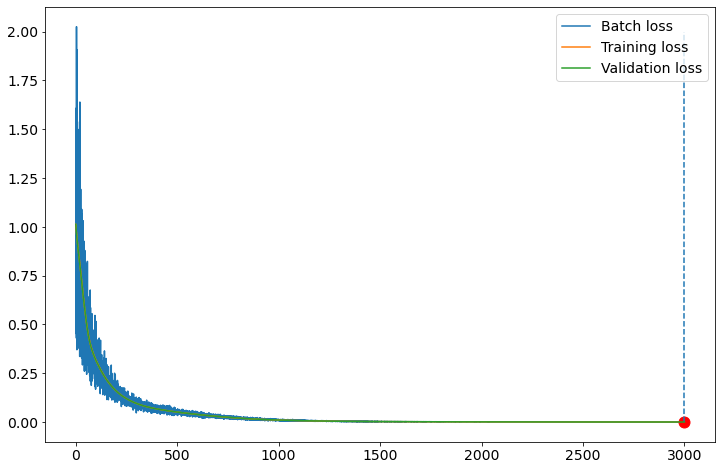

      3100       9300   0.000117   0.000089   0.000085     0.000077(3090)   0.001000
      3200       9600   0.000055   0.000064   0.000062     0.000062(3199)   0.001000
      3300       9900   0.000038   0.000055   0.000053     0.000050(3294)   0.001000
      3400      10200   0.000242   0.000132   0.000267     0.000044(3378)   0.001000
      3500      10500   0.000061   0.000033   0.000034     0.000033(3495)   0.001000
      3600      10800   0.000048   0.000027   0.000028     0.000027(3595)   0.001000
      3700      11100   0.000016   0.000020   0.000018     0.000018(3697)   0.001000
      3800      11400   0.000013   0.000012   0.000014     0.000011(3797)   0.001000
      3900      11700   0.000145   0.000127   0.000213     0.000008(3861)   0.001000
      4000      12000   0.000006   0.000005   0.000005     0.000005(3994)   0.001000


<Figure size 432x288 with 0 Axes>

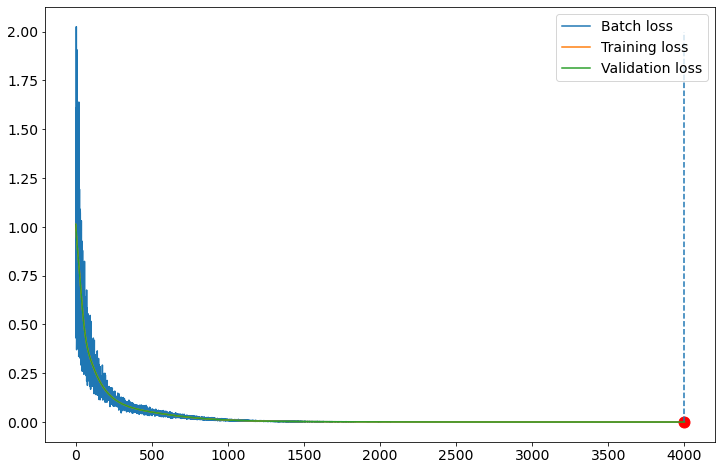

      4100      12300   0.000005   0.000004   0.000004     0.000004(4092)   0.001000
      4200      12600   0.000002   0.000002   0.000003     0.000002(4199)   0.001000
      4300      12900   0.000020   0.000020   0.000093     0.000002(4256)   0.001000
      4400      13200   0.000002   0.000001   0.000001     0.000001(4386)   0.001000
      4500      13500   0.000023   0.000062   0.000021     0.000001(4433)   0.001000
      4600      13800   0.000004   0.000007   0.000002     0.000001(4433)   0.001000
      4700      14100   0.000006   0.000003   0.000008     0.000001(4433)   0.001000
      4800      14400   0.000001   0.000001   0.000000     0.000000(4790)   0.001000
      4900      14700   0.000047   0.000140   0.000059     0.000000(4790)   0.001000
      5000      15000   0.000000   0.000000   0.000000     0.000000(4999)   0.001000


<Figure size 432x288 with 0 Axes>

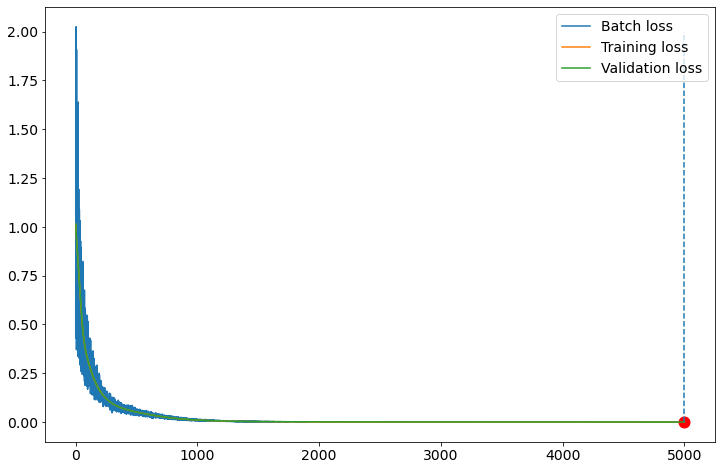

999
   NEpochs   NUpdates  BatchLoss    TrnLoss    ValLoss BestLoss(Epoch)    LrnRate
         1          3   1.024975   0.791484   0.785975     0.785975(0)   0.001000
       100        300   0.309509   0.324819   0.323197     0.323197(99)   0.001000
       200        600   0.205162   0.204216   0.203840     0.203840(199)   0.001000
       300        900   0.154245   0.161494   0.161272     0.161272(299)   0.001000
       400       1200   0.159451   0.132146   0.131996     0.131996(399)   0.001000
       500       1500   0.107821   0.114231   0.114149     0.114149(499)   0.001000
       600       1800   0.078098   0.104729   0.104682     0.104682(599)   0.001000
       700       2100   0.080939   0.099053   0.099021     0.099021(699)   0.001000
       800       2400   0.079954   0.094691   0.094660     0.094660(799)   0.001000
       900       2700   0.098854   0.090714   0.090685     0.090685(899)   0.001000
      1000       3000   0.106380   0.087028   0.087002     0.087002(999)   0.

<Figure size 432x288 with 0 Axes>

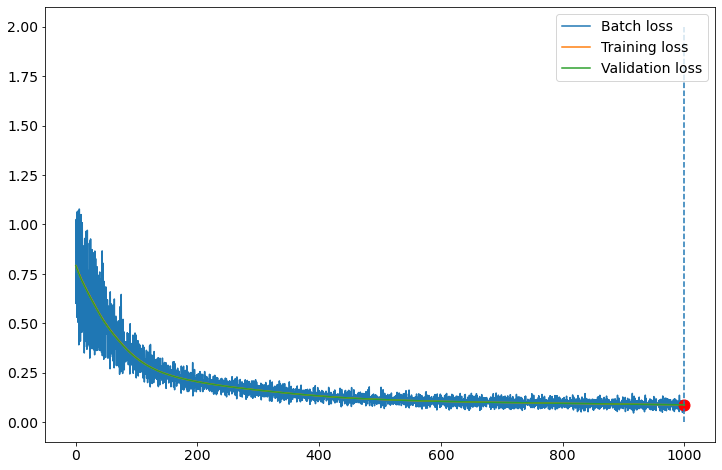

      1100       3300   0.083923   0.083843   0.083822     0.083822(1099)   0.001000
      1200       3600   0.071523   0.081084   0.081064     0.081064(1199)   0.001000
      1300       3900   0.091433   0.078604   0.078589     0.078589(1299)   0.001000
      1400       4200   0.101639   0.076571   0.076557     0.076557(1399)   0.001000
      1500       4500   0.064604   0.074851   0.074836     0.074836(1499)   0.001000
      1600       4800   0.069231   0.073407   0.073402     0.073402(1599)   0.001000
      1700       5100   0.089019   0.072261   0.072251     0.072251(1699)   0.001000
      1800       5400   0.060452   0.071364   0.071359     0.071359(1799)   0.001000
      1900       5700   0.078131   0.070678   0.070673     0.070673(1899)   0.001000
      2000       6000   0.076960   0.070143   0.070138     0.070138(1999)   0.001000


<Figure size 432x288 with 0 Axes>

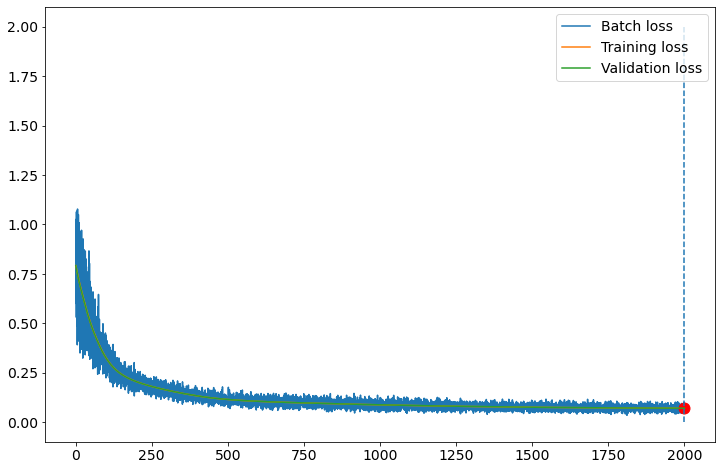

      2100       6300   0.042470   0.069686   0.069687     0.069686(2099)   0.001000
      2200       6600   0.068748   0.069328   0.069332     0.069328(2199)   0.001000
      2300       6900   0.058391   0.069040   0.069039     0.069039(2299)   0.001000
      2400       7200   0.082258   0.068812   0.068811     0.068811(2399)   0.001000
      2500       7500   0.072991   0.068625   0.068624     0.068624(2499)   0.001000
      2600       7800   0.062841   0.068478   0.068477     0.068475(2599)   0.001000
      2700       8100   0.087720   0.068353   0.068350     0.068350(2699)   0.001000
      2800       8400   0.059313   0.068248   0.068253     0.068248(2797)   0.001000
      2900       8700   0.061797   0.068156   0.068158     0.068156(2899)   0.001000
      3000       9000   0.045251   0.068082   0.068083     0.068079(2995)   0.001000


<Figure size 432x288 with 0 Axes>

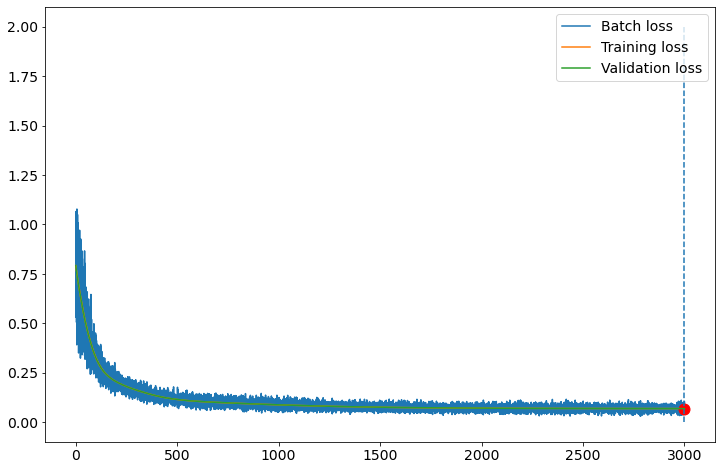

      3100       9300   0.067423   0.068009   0.068015     0.068009(3097)   0.001000
      3200       9600   0.080185   0.067952   0.067952     0.067947(3199)   0.001000
      3300       9900   0.075508   0.067891   0.067887     0.067887(3299)   0.001000
      3400      10200   0.077121   0.067838   0.067838     0.067832(3398)   0.001000
      3500      10500   0.049668   0.067791   0.067793     0.067783(3495)   0.001000
      3600      10800   0.057629   0.067742   0.067735     0.067734(3599)   0.001000
      3700      11100   0.087840   0.067688   0.067696     0.067687(3696)   0.001000
      3800      11400   0.062066   0.067643   0.067655     0.067641(3798)   0.001000
      3900      11700   0.046122   0.067605   0.067603     0.067602(3895)   0.001000
      4000      12000   0.087678   0.067561   0.067558     0.067558(3999)   0.001000


<Figure size 432x288 with 0 Axes>

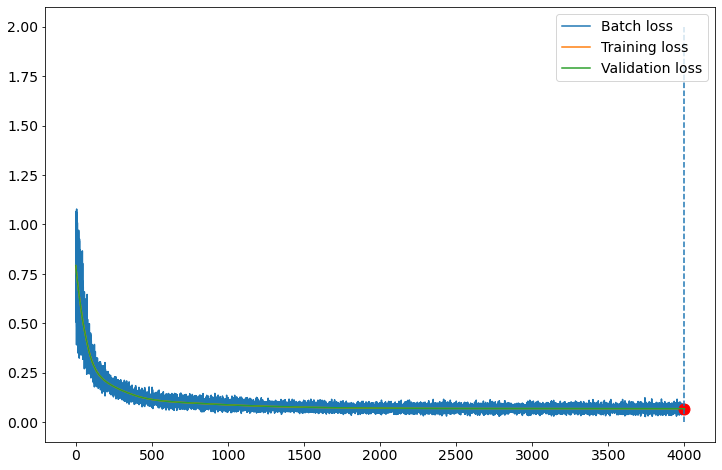

      4100      12300   0.075590   0.067525   0.067526     0.067522(4095)   0.001000
      4200      12600   0.075272   0.067482   0.067483     0.067481(4199)   0.001000
      4300      12900   0.075871   0.067447   0.067455     0.067444(4297)   0.001000
      4400      13200   0.070674   0.067411   0.067410     0.067408(4398)   0.001000
      4500      13500   0.067171   0.067373   0.067378     0.067372(4499)   0.001000
      4600      13800   0.068739   0.067342   0.067351     0.067341(4596)   0.001000
      4700      14100   0.075211   0.067303   0.067318     0.067303(4699)   0.001000
      4800      14400   0.073748   0.067272   0.067273     0.067272(4799)   0.001000
      4900      14700   0.088469   0.067250   0.067294     0.067243(4894)   0.001000
      5000      15000   0.079188   0.067207   0.067219     0.067207(4999)   0.001000


<Figure size 432x288 with 0 Axes>

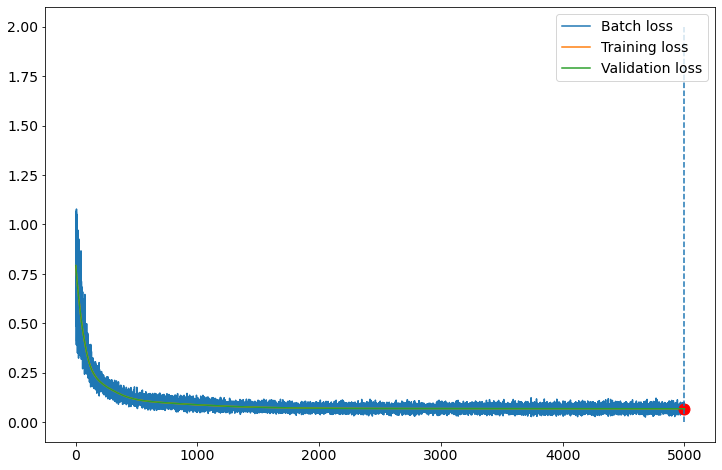

<Figure size 432x288 with 0 Axes>

In [27]:
# Neural Network
kl_surrogate['NN'] = list()
for random_seed in random_seeds:
    print(random_seed)
    #kl_surrogate['NN'].append(
    #    make_nn_surrogate_model(
    #        train_x.values, klxi_train,
    #        cv='KFold',
    #        #cv='LOO',
    #        #test_X=test_x.values, test_Y=klxi_test,
    #        num_hidden_layers=hidden_layers,
    #        lrate=learn_rate,
    #        batch_size=batch_size,
    #        nepochs=nepochs,
    #        seed=random_seed,
    #        eigenratio=eigenratio,
    #    )
    #)
    
    kl_surrogate['NN'].append(
        make_nn_surrogate_model(
            train_x.values, klxi_train.astype(float),
            num_hidden_layers=1, #hidden_layers,
            neurons_per_layer=int((len(variables)+neig)/2)+1,
            lrate=learn_rate,
            batch_size=batch_size,
            nepochs=nepochs,
            seed=random_seed,
            eigenratio=eigenratio,
        )
    )

### Evaluate Models

poly shape: (9,)
parameter common shape: (18,)
output shape: (9, 18)
poly shape: (9,)
parameter common shape: (18,)
output shape: (9, 18)
poly shape: (9,)
parameter common shape: (18,)
output shape: (9, 18)
poly shape: (9,)
parameter common shape: (18,)
output shape: (9, 18)
poly shape: (9,)
parameter common shape: (18,)
output shape: (9, 18)
poly shape: (9,)
parameter common shape: (5,)
output shape: (9, 5)


(a) training
NN MSE_w stats
0.02397979741013529
0.030470479984981477
PC MSE_w stats
0.36182967015814815
0.11845912122799283


poly shape: (9,)
parameter common shape: (5,)
output shape: (9, 5)
poly shape: (9,)
parameter common shape: (5,)
output shape: (9, 5)
poly shape: (9,)
parameter common shape: (5,)
output shape: (9, 5)
poly shape: (9,)
parameter common shape: (5,)
output shape: (9, 5)


(b) test
NN MSE_w stats
1.1970071069595003
0.36999423537509435
PC MSE_w stats
0.9567052876622404
0.08291715822684854


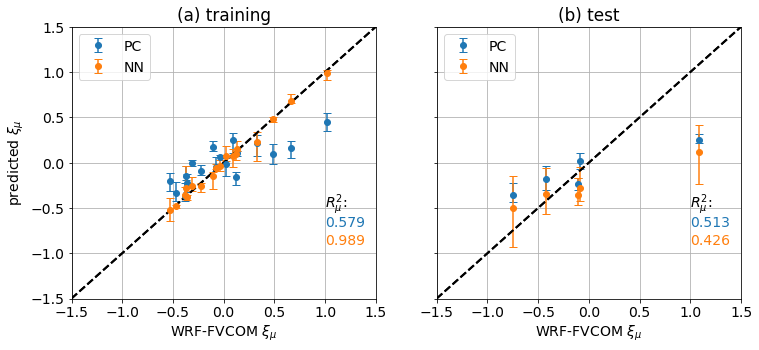

In [28]:
# Checking PC and NN accuracy for sqrt(eigenvalue)-weighted combined
rmse_v = 2
r2_v = -0.5
bnds = 1.5

fig, axs = plt.subplots(1, 2,sharey=True,figsize=(12,5))

for ii in [0,1]:
    
    if ii == 0:
        comparison = '(a) training'
        klxi_model = klxi_train
        # pc
        for ss, sur in enumerate(kl_surrogate['PC']):
            klxi_pred = surrogate_model_predict(sur,train_x)
            if ss == 0:
                klxi_preds0 = klxi_pred[None,:,:]
            else:
                klxi_preds0 = append(klxi_preds0,klxi_pred[None,:,:],axis=0)
        #klxi_pred0 = surrogate_model_predict(kl_surrogate['PC'],train_x)
        # nn
        for ss, sur in enumerate(kl_surrogate['NN']):
            klxi_pred = surrogate_model_predict(sur,train_x.values)
            if ss == 0:
                klxi_preds = klxi_pred[None,:,:]
            else:
                klxi_preds = append(klxi_preds,klxi_pred[None,:,:],axis=0)
        #klxi_pred = surrogate_model_predict(kl_surrogate['NN'],train_x.values)
        #zeros(klxi_model.shape)
        #n_folds = len(kl_surrogate['NN'])
        #for fold_surrogate in kl_surrogate['NN']:
        #    klxi_pred += surrogate_model_predict(fold_surrogate,train_x.values)
        #klxi_pred = klxi_pred / n_folds
    else:
        comparison = '(b) test'
        
        klxi_model = klxi_test
        # pc
        for ss, sur in enumerate(kl_surrogate['PC']):
            klxi_pred = surrogate_model_predict(sur,test_x)
            if ss == 0:
                klxi_preds0 = klxi_pred[None,:,:]
            else:
                klxi_preds0 = append(klxi_preds0,klxi_pred[None,:,:],axis=0)
        #klxi_pred0 = surrogate_model_predict(kl_surrogate['PC'],test_x)
        # nn
        for ss, sur in enumerate(kl_surrogate['NN']):
            klxi_pred = surrogate_model_predict(sur,test_x.values)
            if ss == 0:
                klxi_preds = klxi_pred[None,:,:]
            else:
                klxi_preds = append(klxi_preds,klxi_pred[None,:,:],axis=0)
        #klxi_pred = surrogate_model_predict(kl_surrogate['NN'],test_x.values)
        #klxi_pred = zeros(klxi_model.shape)
        #n_folds = len(kl_surrogate['NN'])
        #for fold_surrogate in kl_surrogate['NN']:
        #    klxi_pred += surrogate_model_predict(fold_surrogate,test_x.values)
        #klxi_pred = klxi_pred / n_folds
        
    #klxi_pred0 = klxi_preds0.mean(axis=0)
    #klxi_errorbars0 = abs(stack((klxi_preds0.min(axis=0),klxi_preds0.max(axis=0))) - klxi_pred0)
    #klxi_pred = klxi_preds.mean(axis=0)
    #klxi_errorbars = abs(stack((klxi_preds.min(axis=0),klxi_preds.max(axis=0))) - klxi_pred)
    
    model_w = (sqrt(eigenvalues)*klxi_model).sum(axis=1)/sqrt(eigenvalues).sum()
    pred_w = {'NN':  zeros(klxi_preds[:,:,0].shape),
              'PC':  zeros(klxi_preds0[:,:,0].shape)}
    mse_w = {'NN':  zeros(klxi_preds[:,:,0].shape[0]),
            'PC':  zeros(klxi_preds0[:,:,0].shape[0])}
    for ss,klxi_pred in enumerate(klxi_preds):
        pred_w['NN'][ss,:] = (sqrt(eigenvalues)*klxi_pred).sum(axis=1)/sqrt(eigenvalues).sum()
        mse_w['NN'][ss] = ((eigenvalues*(klxi_pred - klxi_model)**2).sum(axis=1)/eigenvalues.sum()).mean()
    for ss,klxi_pred0 in enumerate(klxi_preds0):
        pred_w['PC'][ss,:] = (sqrt(eigenvalues)*klxi_pred0).sum(axis=1)/sqrt(eigenvalues).sum()
        mse_w['PC'][ss] = ((eigenvalues*(klxi_pred0 - klxi_model)**2).sum(axis=1)/eigenvalues.sum()).mean()
    
    print(comparison)
    print('NN MSE_w stats')
    print(mse_w['NN'].mean())
    print(mse_w['NN'].std())
    print('PC MSE_w stats')
    print(mse_w['PC'].mean())
    print(mse_w['PC'].std())
    
    axs[ii].text(bnds-0.5,r2_v,'$R^2_\mu$:')
    for st,surrogate_type in enumerate(['PC','NN']):
        pred_wm = pred_w[surrogate_type].mean(axis=0)
        pred_werror = abs(stack((pred_w[surrogate_type].min(axis=0),
                                 pred_w[surrogate_type].max(axis=0))) - pred_wm)
        py = axs[ii].errorbar(model_w, pred_wm,
                              yerr=pred_werror,
                              fmt='o',
                              capsize=4,
                              label=surrogate_type)
        u = ((model_w - pred_wm)**2).sum()
        v = ((model_w - model_w.mean())**2).sum()
        r2 = 1 - u/v
        axs[ii].text(bnds-0.5,r2_v-(1+st)*0.2,str(round(r2,3)),color=py[0].get_color())
        axs[ii].plot([-bnds,bnds], [-bnds,bnds], 'k--', lw=2)
    axs[ii].set_xlabel(r'WRF-FVCOM $\xi_\mu$')
    if ii == 0:
        axs[ii].set_ylabel(r'predicted $\xi_\mu$')
    axs[ii].set_xlim([-bnds,bnds])
    axs[ii].set_ylim([-bnds,bnds])
    axs[ii].set_title(f'{comparison}')
    axs[ii].legend(loc='upper left')
    axs[ii].grid()
plt.show()